In [1]:
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from model import SimpleLSTM, SpacedLSTM
from lstm_functions import quantile_loss, predict_model, plot_forecasts
from data_prep import prepare_data

In [2]:
file_path = '../formatted_data/formatted_data_new.csv'
dense_lookback = 48  # Last 48 hours
forecast_horizon = 24  # Predict next 24 hours
target_col = "DA"
future_cols = ["Andalusia (Wind)_temperature", "Andalusia (Wind)_solar_radiation", "Andalusia (Wind)_wind_u_component", "Andalusia (Wind)_wind_v_component", "Andalusia (Wind)_surface_pressure", "Andalusia (Wind)_total_precipitation", "Aragon (Wind)_temperature", "Aragon (Wind)_solar_radiation", "Aragon (Wind)_wind_u_component", "Aragon (Wind)_wind_v_component", "Aragon (Wind)_surface_pressure", "Aragon (Wind)_total_precipitation", "Barcelona_temperature", "Barcelona_solar_radiation", "Barcelona_wind_u_component", "Barcelona_wind_v_component", "Barcelona_surface_pressure", "Barcelona_total_precipitation", "Bilbao_temperature", "Bilbao_solar_radiation", "Bilbao_wind_u_component", "Bilbao_wind_v_component", "Bilbao_surface_pressure", "Bilbao_total_precipitation", "Castile-La Mancha (Wind)_temperature", "Castile-La Mancha (Wind)_solar_radiation", "Castile-La Mancha (Wind)_wind_u_component", "Castile-La Mancha (Wind)_wind_v_component", "Castile-La Mancha (Wind)_surface_pressure", "Castile-La Mancha (Wind)_total_precipitation", "Escatrón-Chiprana-Samper (Solar)_temperature", "Escatrón-Chiprana-Samper (Solar)_solar_radiation", "Escatrón-Chiprana-Samper (Solar)_wind_u_component", "Escatrón-Chiprana-Samper (Solar)_wind_v_component", "Escatrón-Chiprana-Samper (Solar)_surface_pressure", "Escatrón-Chiprana-Samper (Solar)_total_precipitation", "Madrid_temperature", "Madrid_solar_radiation", "Madrid_wind_u_component", "Madrid_wind_v_component", "Madrid_surface_pressure", "Madrid_total_precipitation", "Seville_temperature", "Seville_solar_radiation", "Seville_wind_u_component", "Seville_wind_v_component", "Seville_surface_pressure", "Seville_total_precipitation", "Talasol Solar (Solar)_temperature", "Talasol Solar (Solar)_solar_radiation", "Talasol Solar (Solar)_wind_u_component", "Talasol Solar (Solar)_wind_v_component", "Talasol Solar (Solar)_surface_pressure", "Talasol Solar (Solar)_total_precipitation", "Talayuela Solar (Solar)_temperature", "Talayuela Solar (Solar)_solar_radiation", "Talayuela Solar (Solar)_wind_u_component", "Talayuela Solar (Solar)_wind_v_component", "Talayuela Solar (Solar)_surface_pressure", "Talayuela Solar (Solar)_total_precipitation", "Valencia_temperature", "Valencia_solar_radiation", "Valencia_wind_u_component", "Valencia_wind_v_component", "Valencia_surface_pressure", "Valencia_total_precipitation", "Hour_Sin", "Hour_Cos", "Day_Sin", "Day_Cos", "Month_Sin", "Month_Cos", "Demand"]
quantiles = [0.2, 0.5, 0.8]

# Prepare datasets
train_dense_past, train_future, train_targets, val_dense_past, val_future, val_targets, test_dense_past, test_future, test_targets, target_scaler = prepare_data(
    file_path=file_path,
    dense_lookback=dense_lookback,
    spaced_lookback=0,
    forecast_horizon=forecast_horizon,
    future_cols=future_cols,
    target_col=target_col,
    spaced=False
)

# Create DataLoaders
train_loader = DataLoader(
    TensorDataset(train_dense_past, train_future, train_targets),
    batch_size=128,
    shuffle=True,
)
val_loader = DataLoader(
    TensorDataset(val_dense_past, val_future, val_targets),
    batch_size=128,
    shuffle=False,
)
test_loader = DataLoader(
    TensorDataset(test_dense_past, test_future, test_targets),
    batch_size=1,
    shuffle=False,
)

usable_hours: 16734
train: (11713, 48, 82)
test: (2511, 48, 82)
val: (2510, 48, 82)
train_targets: (11713, 24, 1)
test_targets: (2511, 24, 1)
val_targets: (2510, 24, 1)
train_future: (11713, 24, 73)
test_future: (2511, 24, 73)
val_future: (2510, 24, 73)


In [3]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = SimpleLSTM(
    past_input_size=train_dense_past.shape[2],
    future_input_size=len(future_cols),
    hidden_size=128,
    num_layers=2,
    dropout=0.2,
    past_horizons=train_dense_past.shape[1],
    forecast_horizon=forecast_horizon,
    quantiles=quantiles,
).to(device)

optimizer1 = torch.optim.AdamW(model1.parameters(), lr=0.0005, weight_decay=1e-4)

In [4]:
def plot_training_validation_loss(train_losses, val_losses):
    """
    Plots training and validation losses.
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
# Training and Validation Function for Forked Training
def train_and_val(train_loader, val_loader, num_epochs, model, optimizer, quantiles, device):
    """
    Trains and validates the model using both past and future data simultaneously.
    """
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss = 0
        for batch_idx, (past_inputs, future_inputs, targets) in enumerate(train_loader):
            past_inputs, future_inputs, targets = (
                past_inputs.to(device).float(),
                future_inputs.to(device).float(),
                targets.to(device).float(),
            )

            optimizer.zero_grad()
            forecasts = model(past_inputs, future_inputs)
            loss = quantile_loss(targets, forecasts, quantiles)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= (batch_idx + 1)
        train_losses.append(train_loss)

        # Validation Phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_idx, (past_inputs, future_inputs, targets) in enumerate(val_loader):
                past_inputs, future_inputs, targets = (
                    past_inputs.to(device).float(),
                    future_inputs.to(device).float(),
                    targets.to(device).float(),
                )

                forecasts = model(past_inputs, future_inputs)
                loss = quantile_loss(targets, forecasts, quantiles)
                val_loss += loss.item()

        val_loss /= (batch_idx + 1)
        val_losses.append(val_loss)

        print(
            f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}"
        )

    # Plot Training and Validation Losses
    plot_training_validation_loss(train_losses, val_losses)
    return model, train_losses, val_losses

In [6]:
# Train model
simple_model, train_losses, val_losses = train_and_val(
    train_loader, val_loader, num_epochs=25, model=model1, optimizer=optimizer1, quantiles=quantiles, device=device
)
# # Predict
forecast_inv, true_inv = predict_model(simple_model, test_loader, target_scaler, quantiles=quantiles, forecast_horizon=24, device=device)

# # Plot results
plot_forecasts(forecast_inv, true_inv, quantiles=quantiles, forecast_horizon=24)

Epoch [1/25], Training Loss: 0.0805, Validation Loss: 0.0667
Epoch [2/25], Training Loss: 0.0625, Validation Loss: 0.0698
Epoch [3/25], Training Loss: 0.0452, Validation Loss: 0.0589
Epoch [4/25], Training Loss: 0.0383, Validation Loss: 0.0569
Epoch [5/25], Training Loss: 0.0352, Validation Loss: 0.0523
Epoch [6/25], Training Loss: 0.0340, Validation Loss: 0.0591
Epoch [7/25], Training Loss: 0.0324, Validation Loss: 0.0512
Epoch [8/25], Training Loss: 0.0312, Validation Loss: 0.0542
Epoch [9/25], Training Loss: 0.0297, Validation Loss: 0.0546


KeyboardInterrupt: 

In [8]:
# Parameters
dense_lookback = 48  # Last 48 hours
spaced_lookback = 180*24  # Past 2 years spaced lookback with dynamic steps

# Prepare datasets with dense and spaced inputs
(
    train_dense_past,
    train_spaced_past,
    train_future,
    train_targets,
    val_dense_past,
    val_spaced_past,
    val_future,
    val_targets,
    test_dense_past,
    test_spaced_past,
    test_future,
    test_targets,
    target_scaler,
) = prepare_data(
    file_path=file_path,
    dense_lookback=dense_lookback,
    spaced_lookback=spaced_lookback,
    forecast_horizon=forecast_horizon,
    future_cols=future_cols,
    target_col=target_col,
    spaced=True,
    step_growth_factor=1,
)

# Create DataLoaders
train_loader = DataLoader(
    list(zip(train_dense_past, train_spaced_past, train_future, train_targets)),
    batch_size=64,
    shuffle=True,
)
val_loader = DataLoader(
    list(zip(val_dense_past, val_spaced_past, val_future, val_targets)),
    batch_size=64,
    shuffle=False,
)
test_loader = DataLoader(
    list(zip(test_dense_past, test_spaced_past, test_future, test_targets)),
    batch_size=1,
    shuffle=False,
)



usable_hours: 12462
train: (8723, 48, 82)
test: (1846, 48, 82)
val: (1869, 48, 82)
train_targets: (8723, 24, 1)
test_targets: (1846, 24, 1)
val_targets: (1869, 24, 1)
train_future: (8723, 24, 73)
test_future: (1846, 24, 73)
val_future: (1869, 24, 73)
train_spaced_past: (8723, 180, 82)
test_spaced_past: (1846, 180, 82)
val_spaced_past: (1869, 180, 82)


In [9]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = SpacedLSTM(
    dense_input_size=train_dense_past.shape[2],
    spaced_input_size=train_spaced_past.shape[2],
    future_input_size=len(future_cols),
    hidden_size=128,
    num_layers=2,
    dropout=0.2,
    dense_horizons=dense_lookback,
    spaced_horizons=train_spaced_past.shape[1],
    forecast_horizon=forecast_horizon,
    quantiles=quantiles,
).to(device)

# Optimizer
optimizer2 = torch.optim.AdamW(model2.parameters(), lr=0.0005, weight_decay=1e-4)

In [10]:
def train_and_val(train_loader, val_loader, num_epochs, model, optimizer, quantiles, device):
    """
    Train and validate the SpacedLSTM model using dense, spaced, and future data.
    
    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        num_epochs (int): Number of epochs for training.
        model (nn.Module): The SpacedLSTM model to train.
        optimizer (torch.optim.Optimizer): Optimizer for model training.
        quantiles (list): List of quantiles for loss calculation.
        device (torch.device): Device to run training on ('cpu' or 'cuda').
    
    Returns:
        model (nn.Module): The trained model.
        train_losses (list): List of average training losses per epoch.
        val_losses (list): List of average validation losses per epoch.
    """
    train_losses, val_losses = [], []

    for epoch in range(1, num_epochs + 1):
        # Training Phase
        model.train()
        epoch_train_loss = 0
        for batch_idx, (dense_inputs, spaced_inputs, future_inputs, targets) in enumerate(train_loader):
            # Move data to the specified device
            dense_inputs, spaced_inputs, future_inputs, targets = (
                dense_inputs.to(device).float(),
                spaced_inputs.to(device).float(),
                future_inputs.to(device).float(),
                targets.to(device).float(),
            )

            # Forward pass
            optimizer.zero_grad()
            forecasts = model(dense_inputs, spaced_inputs, future_inputs)

            # Calculate loss
            loss = quantile_loss(targets, forecasts, quantiles)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        # Average training loss for the epoch
        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        # Validation Phase
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch_idx, (dense_inputs, spaced_inputs, future_inputs, targets) in enumerate(val_loader):
                # Move data to the specified device
                dense_inputs, spaced_inputs, future_inputs, targets = (
                    dense_inputs.to(device).float(),
                    spaced_inputs.to(device).float(),
                    future_inputs.to(device).float(),
                    targets.to(device).float(),
                )

                # Forward pass
                forecasts = model(dense_inputs, spaced_inputs, future_inputs)

                # Calculate loss
                loss = quantile_loss(targets, forecasts, quantiles)
                epoch_val_loss += loss.item()

        # Average validation loss for the epoch
        epoch_val_loss /= len(val_loader)
        val_losses.append(epoch_val_loss)

        # Log epoch results
        print(
            f"Epoch [{epoch}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}"
        )

    # Plot Training and Validation Losses
    plot_training_validation_loss(train_losses, val_losses)

    return model, train_losses, val_losses

Epoch [1/5], Training Loss: 0.1304, Validation Loss: 0.0537
Epoch [2/5], Training Loss: 0.0554, Validation Loss: 0.0465
Epoch [3/5], Training Loss: 0.0471, Validation Loss: 0.0399
Epoch [4/5], Training Loss: 0.0445, Validation Loss: 0.0437
Epoch [5/5], Training Loss: 0.0426, Validation Loss: 0.0396


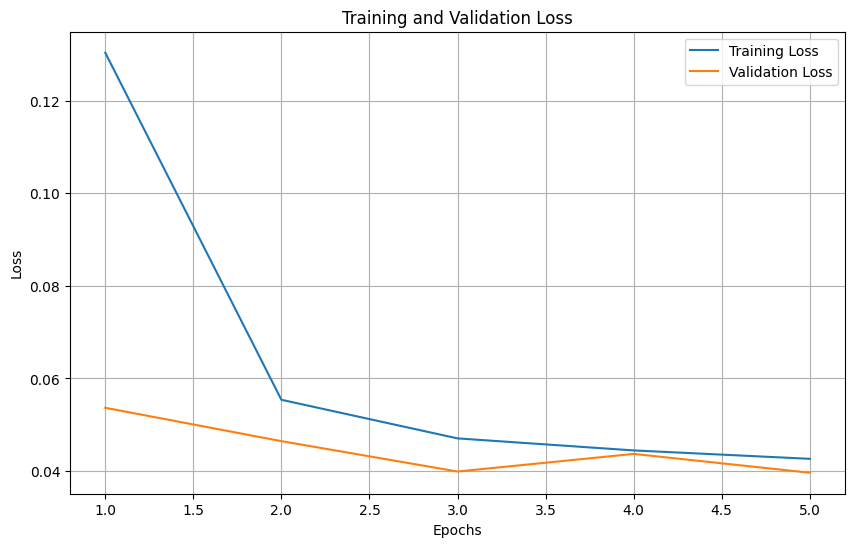

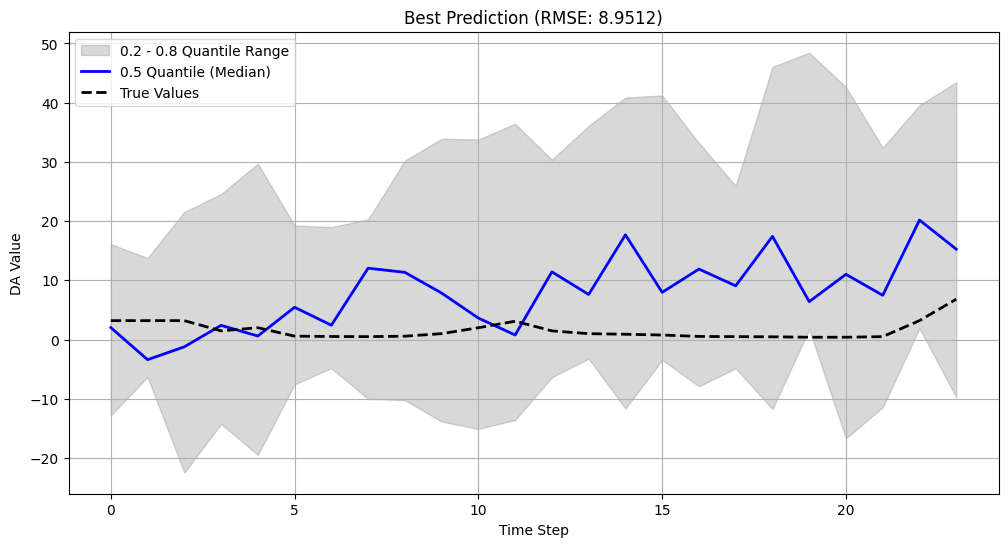

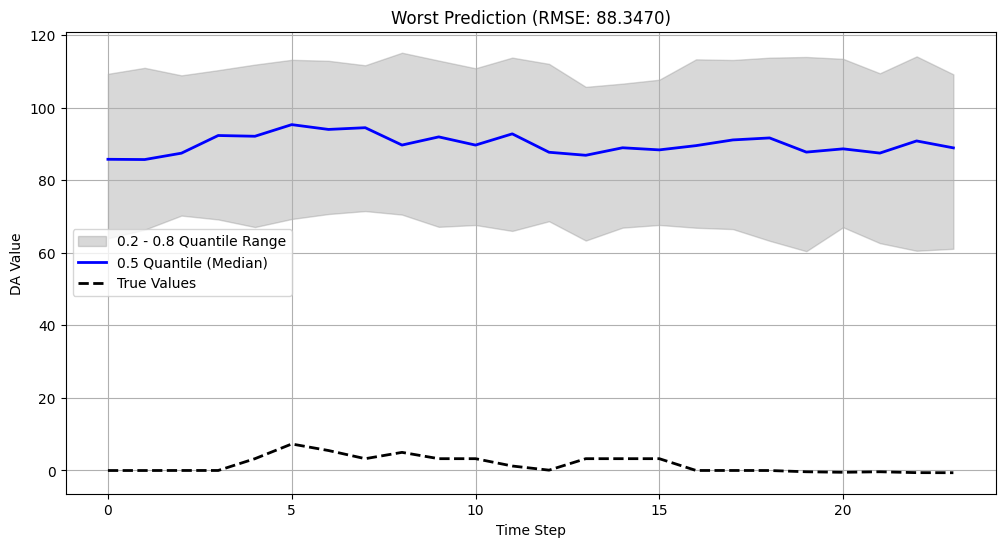

In [12]:
# Train model
spaced_model, train_losses, val_losses = train_and_val(
    train_loader, val_loader, num_epochs=5, model=model2, optimizer=optimizer2, quantiles=quantiles, device=device
)
# # Predict
forecast_inv, true_inv = predict_model(spaced_model, test_loader, target_scaler, quantiles=quantiles, forecast_horizon=24, device=device, spaced=True)

# # Plot results
plot_forecasts(forecast_inv, true_inv, quantiles=quantiles, forecast_horizon=24)